## Importing Modules

In [1]:
!pip install einops
import torch as t
import pytest
import tempfile
import os
import time
import torch as t
from torch import nn
import transformers
import joblib
import requests
import logging
import http
from functools import wraps
from transformers.models.bert.modeling_bert import BertForMaskedLM
from transformers.models.gpt2.modeling_gpt2 import GPT2LMHeadModel
from typing import Optional, Iterator, cast, TypeVar, Generic, Callable

mem = joblib.Memory(tempfile.gettempdir() + "/joblib_cache")
DEBUG_TOLERANCES = os.getenv("DEBUG_TOLERANCES")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
## Helper methods
def allclose(actual: t.Tensor, expected: t.Tensor, rtol=1e-4) -> None:
    assert_shape_equal(actual, expected)
    left = (actual - expected).abs()
    right = rtol * expected.abs()
    num_wrong = (left > right).sum().item()
    if num_wrong > 0:
        print(f"Test failed. Max absolute deviation: {left.max()}")
        print(f"Actual:\n{actual}\nExpected:\n{expected}")
        raise AssertionError(f"allclose failed with {num_wrong} / {left.nelement()} entries outside tolerance")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with max absolute deviation of {left.max()}")
   

def report_success(testname):
    """POST to the server indicating success at the given test.

    Used to help the TAs know how long each section takes to complete.
    """
    server = os.environ.get("MLAB_SERVER")
    email = os.environ.get("MLAB_EMAIL")
    if server:
        if email:
            r = requests.post(
                server + "/api/report_success",
                json=dict(email=email, testname=testname),
            )
            if r.status_code != http.HTTPStatus.NO_CONTENT:
                raise ValueError(f"Got status code from server: {r.status_code}")
        else:
            raise ValueError(f"Server set to {server} but no MLAB_EMAIL set!")
    else:
        if email:
            raise ValueError(f"Email set to {email} but no MLAB_SERVER set!")
        else:
            return  # local dev, do nothing
        
TEST_FN_PASSED = {}
def report(test_func):
    name = f"{test_func.__module__}.{test_func.__name__}"
    # This can happen when using autoreload, so don't complain about it.
    # if name in TEST_FN_PASSED:
    #     raise KeyError(f"Already registered: {name}")
    TEST_FN_PASSED[name] = False

    @wraps(test_func)
    def wrapper(*args, **kwargs):
        return run_and_report(test_func, name, *args, **kwargs)

    return wrapper

def run_and_report(test_func: Callable, name: str, *test_func_args, **test_func_kwargs):
    start = time.time()
    out = test_func(*test_func_args, **test_func_kwargs)
    elapsed = time.time() - start
    print(f"{name} passed in {elapsed:.2f}s.")
    if not TEST_FN_PASSED.get(name):
        report_success(name)
        TEST_FN_PASSED[name] = True
    return out


def assert_all_equal(actual: t.Tensor, expected: t.Tensor) -> None:
    """Assert that actual and expected are exactly equal (to floating point precision)."""
    mask = actual == expected
    if not mask.all().item():
        bad = mask.nonzero()
        msg = f"Did not match at {len(bad)} indexes: {bad[:10]}{'...' if len(bad) > 10 else ''}"
        raise AssertionError(f"{msg}\nActual:\n{actual}\nExpected:\n{expected}")
        


def make_rays_1d_solution(num_pixels : int, y_limit : float) -> t.Tensor:
    
    rays = t.zeros((num_pixels, 2, 3), dtype = t.float32)
    t.linspace(-y_limit, y_limit, num_pixels, out = rays[:, 1, 1])
    rays[:, 1, 0] = 1
    return rays

@report
def test_intersect_ray_1d(intersact_ray_1d):
    segments = t.tensor(
    [[[1.0, -12.0, 0.0], [1, -6.0, 0.0]], [[0.5, 0.1, 0.0], [0.5, 1.15, 0.0]], [[2, 12.0, 0.0], [2, 21.0, 0.0]]])
    
    expected = [(0, 0), (0, 1), (2, 7), (2, 8)]
    actual = []
    rays = make_rays_1d_solution(9, 10.0)
    for i, segment in enumerate(segments):
        for j, ray in enumerate(rays):
            if intersact_ray_1d(ray, segment):
                actual.append((i, j))
                
    if expected != actual:
        print("Expected segment-ray intersections: ", expected)
        print("Actual:", actual)
        
    assert expected == actual
    

@report
def test_intersect_ray_1d_special_case(intersect_ray_1d):
    ray = t.tensor([[0.0, 0.0, 0.0], [0.0, 1.0, 1.0]])
    segment = t.tensor([[0.0, 2.0, 2.0], [0.0, 4.0, 4.0]])
    actual = intersect_ray_1d(ray, segment)
    assert actual == False
    
@report
def test_intersect_rays_1d(intersect_rays_1d):
    
    segments = t.tensor(
    [[[1.0, -12.0, 0.0], [1, -6.0, 0.0]], [[0.5, 0.1, 0.0], [0.5, 1.15, 0.0]], [[2, 12.0, 0.0], [2, 21.0, 0.0]]])
    rays = make_rays_1d_solution(9, 10.0)
    expected = t.tensor([True, True, False, False, False, False, False, True, True])
    actual = intersect_rays_1d(rays, segments)
    assert_all_equal(actual , expected)
    

@report
def test_intersect_rays_1d_special_case(intersect_rays_1d):
    ray = t.tensor([[[0.0, 0.0, 0.0], [0.0, 1.0, 1.0]], [[0.0, 0.0, 0.0], [1.0, -10.0, 0.0]]])
    segment = t.tensor(
        [
            [[0.0, 2.0, 2.0], [0.0, 4.0, 4.0]],
            [[1.0, -12.0, 0.0], [1.0, -6.0, 0.0]],
        ]
    )
    actual = intersect_rays_1d(ray, segment)
    expected = t.tensor([False, True])
    assert_all_equal(actual, expected)
    
@report
def test_triangle_line_intersects(triangle_line_intersects):
    A = t.tensor([2, 0.0, -1.0])
    B = t.tensor([2, -1.0, 0.0])
    C = t.tensor([2, 1.0, 1.0])
    O = t.tensor([0.0, 0.0, 0.0])
    D = t.tensor([1.0000, 0.3333, 0.3333])
    assert triangle_line_intersects(A, B, C, O, D)

    O2 = t.tensor([0.0, 0.0, 0.0])
    D2 = t.tensor([1.0, 1.0, -1.0])
    assert not triangle_line_intersects(A, B, C, O2, D2)
        
        
    

In [3]:
import os
import torch as t
import einops
import matplotlib.pyplot as plt
from ipywidgets import interact

MAIN = __name__ == "__main__"
IS_CI = os.getenv("IS_CI")

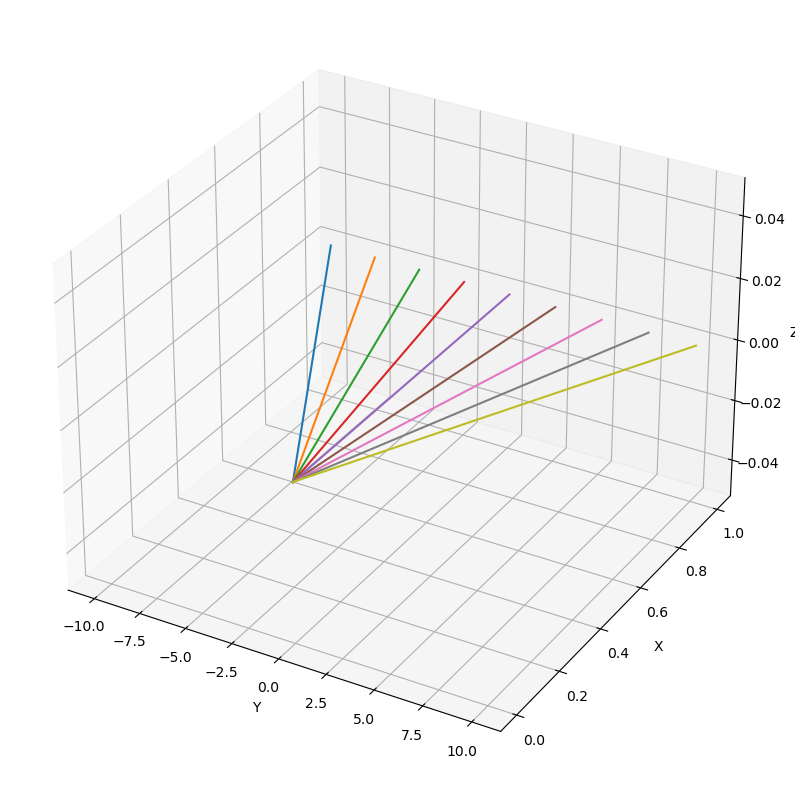

In [4]:
def make_rays_1d(num_pixels : int, y_limit : float) -> t.Tensor:
    
    """
    num_pixels : The number of pixels in the y dimension. Since there is one ray per pixel, this is also the number of rays.
    y_limit : At x = 1, the rays should extend from -y_limit to +y_limit, inclusive of both endpoints.
    
    Returns : shape (num_pixels, num_points = 2, num_dim = 3) where the num_points dimension contains (origin, direction) and the num_dim dimension contains xyz.
    
    Example of make_rays_1d(9, 1.0): [
        [[0, 0, 0], [1, -1.0, 0]],
        [[0, 0, 0], [1, -0.75, 0]],
        [[0, 0, 0], [1, -0.5, 0]],
        ...
        [[0, 0, 0], [1, 0.75, 0]],
        [[0, 0, 0], [1, 1, 0]],
    ]
    """
    
    y_coords = t.linspace(-y_limit, y_limit, num_pixels)
    rays = t.zeros((num_pixels, 2, 3))
    rays[:, 1, 0] = 1
    rays[:, 1, 1] = y_coords
    return rays

def render_lines_with_pyplot(lines : t.Tensor):
    
    """Plot any number of line segments in 3D.

    lines: shape (num_lines, num_points=2, num_dims=3).
    """
    (fig, ax) = plt.subplots(figsize = (10, 10), subplot_kw = {'projection' : '3d'})
    for line in lines:
        ax.plot(line[:, 1].numpy(), line[:, 0].numpy(), line[:, 2].numpy())
    ax.set(xlabel = 'Y', ylabel = 'X', zlabel = 'Z')
    return fig

rays1d = make_rays_1d(9, 10.0)
if MAIN and (not IS_CI):
    render_lines_with_pyplot(rays1d)

In [5]:
@interact
def line(v = (-2.0, 2.0), seed = (0, 10)):
    
    """
    Interactive line widget.
    
    Drag "seed" to get a different random line.
    Drag "v" to see that v must be in [0, 1] for the intersection marked by a star to be "inside" the object line.
    
    """
    t.manual_seed(seed)
    L_1 = t.randn(2)
    L_2 = t.randn(2)
    P = lambda v : L_1 + v * (L_2 - L_1)
    (x, y) = zip(P(-2), P(2))
    plt.plot(x, y, "g-")
    plt.plot(*L_1, "ro", markersize=12)
    plt.plot(*L_2, "ro", markersize=12)
    plt.plot(P(v)[0], P(v)[1], "*", markersize=12)
    plt.xlabel("X")
    plt.ylabel("Y")
    

interactive(children=(FloatSlider(value=0.0, description='v', max=2.0, min=-2.0), IntSlider(value=5, descripti…

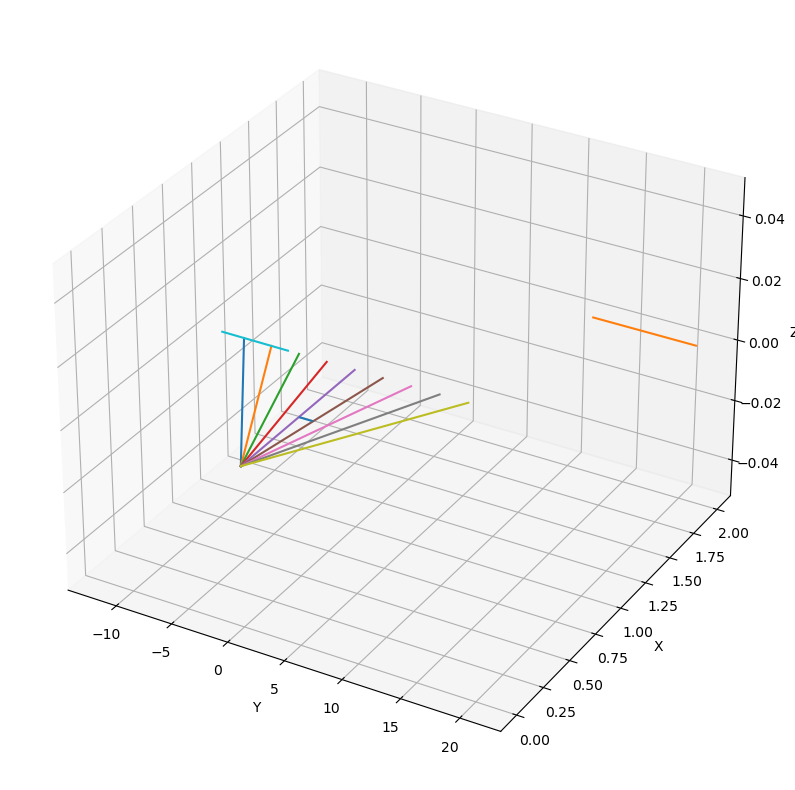

In [6]:
segments = t.tensor(
    [[[1.0, -12.0, 0.0], [1, -6.0, 0.0]], [[0.5, 0.1, 0.0], [0.5, 1.15, 0.0]], [[2, 12.0, 0.0], [2, 21.0, 0.0]]]
)

rays1d_concat = t.cat((rays1d, segments), 0)

if MAIN and (not IS_CI):
    render_lines_with_pyplot(rays1d_concat)

In [7]:
def intersect_ray_1d(ray : t.Tensor, segment : t.Tensor) -> bool:
    
    """
    rays: shape (NR, 2, 3) - NR is the number of rays
    segments: shape (NS, 2, 3) - NS is the number of segments

    Return: shape (NR, )
    """
    
    try:
        ray = ray[:, :2]
        segment = segment[:, :2]
        L1 = segment[0]
        L2 = segment[1]
        O = ray[0]
        d = ray[1]
        LHS = t.stack([d, L1 - L2], dim = -1)
        RHS = L1 - O
        assert LHS.shape == (2, 2)
        assert RHS.shape == (2,)
        intersection_point = t.linalg.solve(LHS, RHS)
    except:
        return False
    u = intersection_point[0].item()
    v = intersection_point[1].item()
    return (u >= 0.0) and (v >= 0.0) and (v <= 1.0)


test_intersect_ray_1d(intersect_ray_1d)
test_intersect_ray_1d_special_case(intersect_ray_1d)

__main__.test_intersect_ray_1d passed in 0.03s.
__main__.test_intersect_ray_1d_special_case passed in 0.04s.


In [8]:
def intersect_rays_1d(rays : t.Tensor, segment : t.Tensor) -> t.Tensor:
    
    """
    rays : shape (NR, 2, 3) - NR is number of rays
    segments : shape (NS, 2, 3) - NS is number of segments
    
    Return : shape (NR)
    """
    
    rays = rays[..., :2]
    segments = segment[..., :2]
    
    rays = einops.repeat(rays, 'num_rays num_points num_coords -> num_rays num_segments num_points num_coords', num_segments = segments.shape[0])
    segments = einops.repeat(segments, 'num_segments num_points num_coords -> num_rays num_segments num_points num_coords', num_rays = rays.shape[0])
    
    L1 = segments[..., 0, :]
    L2 = segments[..., 1, :]
    O = rays[..., 0, :]
    d = rays[..., 1, :]
    
    
    LHS = t.stack([d, L1 - L2], dim = -1)
    RHS = L1 - O
    dets = t.linalg.det(LHS)
    
    # No solution
    is_singular = dets.abs() < 1e-8
    LHS[is_singular] = t.eye(2)
    
    sol = t.linalg.solve(LHS, RHS)
    u = sol[..., 0]
    v = sol[..., 1]
    return ((u >= 0) & (v >= 0) * (v <= 1) & ~is_singular).any(dim = -1)
    
    
    
    
test_intersect_rays_1d(intersect_rays_1d)
test_intersect_rays_1d_special_case(intersect_rays_1d)

__main__.test_intersect_rays_1d passed in 0.02s.
__main__.test_intersect_rays_1d_special_case passed in 0.00s.


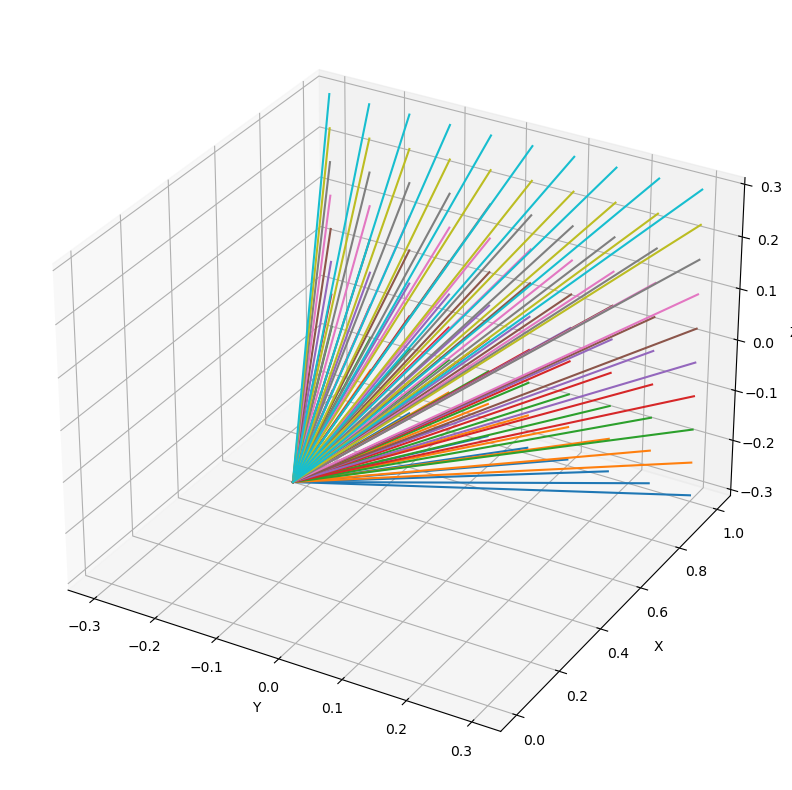

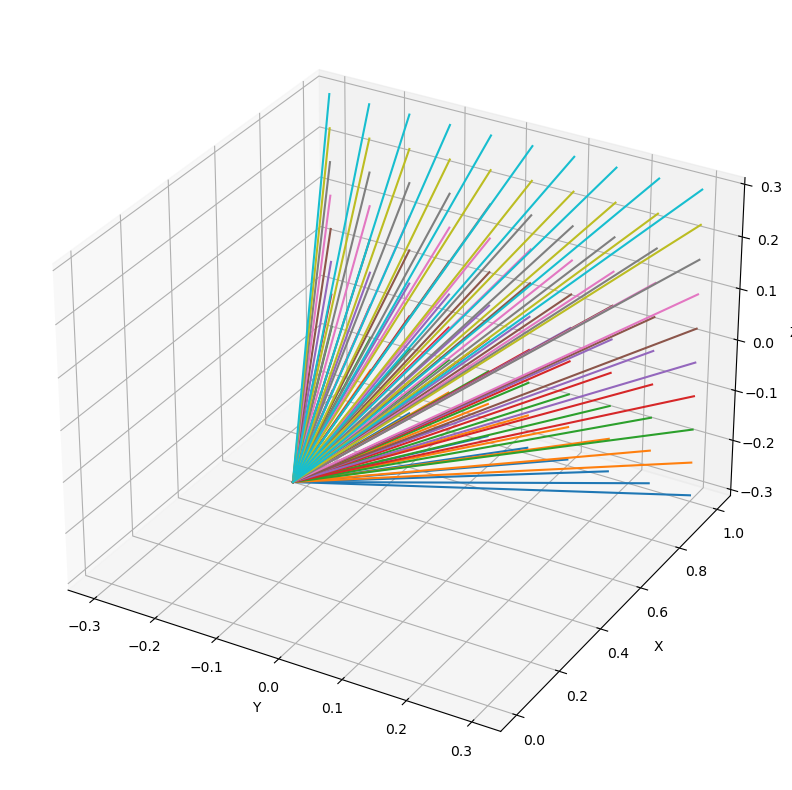

In [9]:
def make_rays_2d(num_pixels_y : int, num_pixels_z,
                y_limit : float, z_limit : float) -> t.Tensor:
    
    """
    num_pixels_y: The number of pixels in the y dimension.
    num_pixels_z: The number of pixels in the z dimension.
    
    y_limit: At x=1, the rays should extend from -y_limit to +y_limit, inclusive of both.
    z_limit: At x=1, the rays should extend from -z_limit to +z_limit, inclusive of both.
    
    Returns: shape(num_rays = num_pixels_y * num_pixels_z, num_points=2, num_dims=3).
    """
    y_coords = t.linspace(-y_limit, y_limit, num_pixels_y)
    z_coords = t.linspace(-z_limit, z_limit, num_pixels_z)
    
    rays = t.zeros((num_pixels_y * num_pixels_z, 2, 3))
    grid_y, grid_z = t.meshgrid(y_coords, z_coords, indexing = 'ij')
    rays[:, 1, 0] = 1
    rays[:, 1, 1] = grid_y.reshape(-1)
    rays[:, 1, 2] = grid_z.reshape(-1)
    return rays
    
    
rays_2d = make_rays_2d(10, 10, 0.3, 0.3)
render_lines_with_pyplot(rays_2d)

In [10]:
one_triangle = t.tensor([[0, 0, 0], [3, 0.5, 0], [2, 3, 0]])

@interact
def triangle(u = (-1.0, 2.0), v = (-1.0, 2.0)):
    (A, B, C) = one_triangle
    for p in (A, B, C):
        plt.plot(p[0], p[1], "ro", markersize = 12)
    for (p, q) in ((A, B), (B, C), (C, A)):
        (x, y, _) = zip(p, q)
        plt.plot(x, y, "g-")
    P = A + u * (B - A) + v * (C - A)
    plt.plot(P[0], P[1], "*", markersize=12)
    plt.xlabel("X")
    plt.ylabel("Y")

interactive(children=(FloatSlider(value=0.5, description='u', max=2.0, min=-1.0), FloatSlider(value=0.5, descr…

In [11]:
def triangle_line_intersects(A : t.Tensor, B : t.Tensor,
                            C : t.Tensor, O : t.Tensor,
                            D : t.Tensor) -> bool:
    
    """
    A : shape(3,), one vertex of the triangle
    B : shape(3,), second vertex of the triangle
    C : shape(3,), third vertex of the triangle
    O : shape(3,), origin point
    D : shape(3,), direction point
    
    Return True if the line and the triangle intersect.
    """
    
    LHS = A - O
    RHS = t.stack([D, A-B, A-C], dim = -1)
    _, u, v = t.linalg.solve(RHS, LHS)
    return ((0 < u) & (0 < v) & (u + v < 1)).item()
    
    
    
test_triangle_line_intersects(triangle_line_intersects)

__main__.test_triangle_line_intersects passed in 0.00s.


[Text(0.5, 0, 'Y'), Text(0, 0.5, 'Z')]

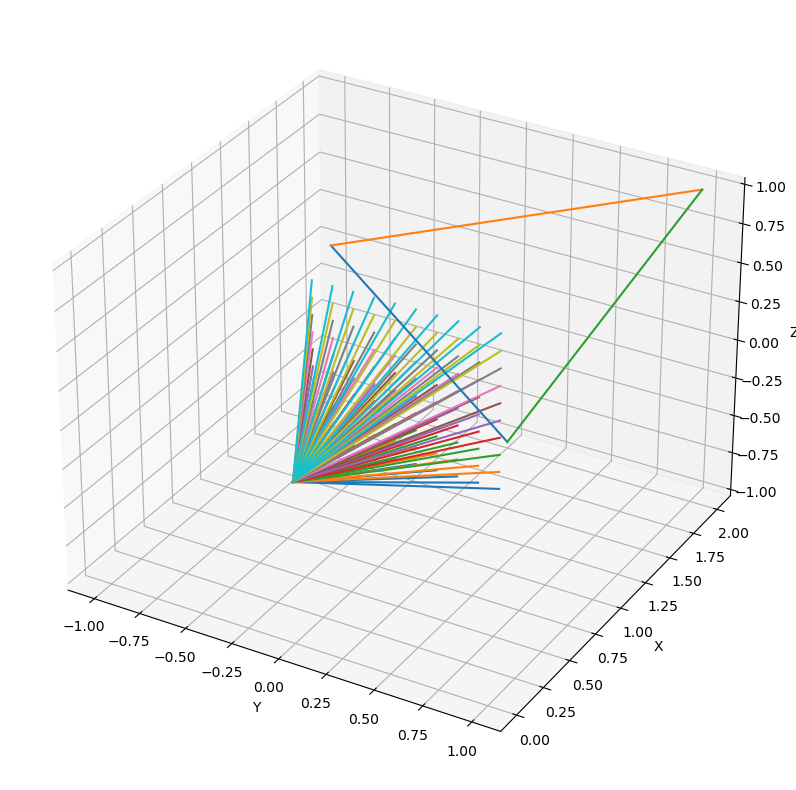

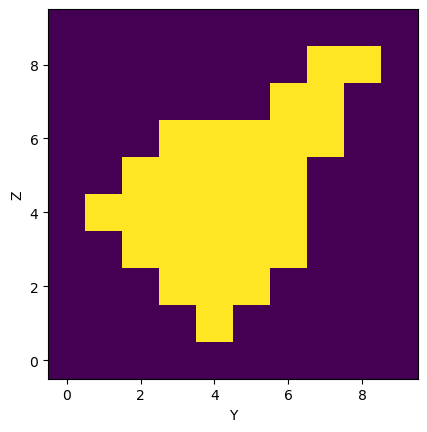

In [20]:
def raytrace_triangle(triangle : t.Tensor, rays : t.Tensor) -> t.Tensor:
    
    """
    For each ray, return True if the triangle intersects that ray.
    
    triangle : shape(n_points=3, n_dims = 3)
    rays : shape(n_pixels, n_points = 2, n_dims = 3)
    
    return : shape(n_pixels, )
    """
    A, B, C = triangle
    O = rays[:, 0]
    d = rays[:, 1]
    
    num_rays = rays.shape[0]
    A = einops.repeat(A, 'num_coords -> num_rays num_coords', num_rays = num_rays)
    B = einops.repeat(B, 'num_coords -> num_rays num_coords', num_rays = num_rays)
    C = einops.repeat(C, 'num_coords -> num_rays num_coords', num_rays = num_rays)
    
    RHS = t.stack([d, A-B, A-C], dim = -1)
    dets = t.linalg.det(RHS)
    is_singular = dets.abs() < 1e-8
    RHS[is_singular] = t.eye(3)
    
    LHS = A - O
    intersection = t.linalg.solve(RHS, LHS)
    u = intersection[:, 1]
    v = intersection[:, 2]
    intersects = (0 < u) & (0 < v) & (u + v < 1) & ~is_singular
    return intersects
    
    
    
    
A = t.tensor([2, 0.0, -1.0])
B = t.tensor([2, -1.0, 0.0])
C = t.tensor([2, 1.0, 1.0])
num_pixels_y = num_pixels_z = 10
y_limit = z_limit = 0.5

test_triangle = t.stack([A, B, C], dim = 0)
rays2d = make_rays_2d(num_pixels_y, num_pixels_z, y_limit, z_limit)
triangle_lines = t.stack([A, B, B, C, A, C], dim = 0).reshape(-1, 2, 3)
render_lines_with_pyplot(t.cat([rays2d, triangle_lines]))
intersects = raytrace_triangle(test_triangle, rays2d)
img = intersects.reshape(num_pixels_y, num_pixels_z)
fig, ax = plt.subplots()
ax.imshow(img, origin="lower")
ax.set(xlabel="Y", ylabel="Z")

In [21]:
with open('/kaggle/input/mlab-pikachu/w1d1_pikachu.pt', 'rb') as f:
    triangles = t.load(f)

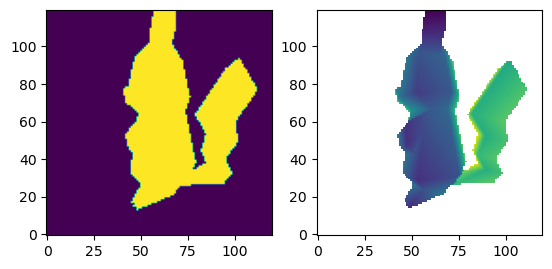

In [33]:
def raytrace_mesh(triangles : t.Tensor, rays : t.Tensor) -> t.Tensor:
    
    """
    For each ray, return the distance to the closest intersecting triangle, or infinity.
    
    triangles : shape(n_triangles, n_points = 3, n_dims = 3)
    rays : shape(n_pixels, n_points = 2, n_dims = 3)
    
    return : shape(n_pixels, )
    
    """
    num_rays = rays.shape[0]
    num_triangles = triangles.shape[0]
    
    O = einops.repeat(rays[:, 0], "num_rays num_coords -> (num_rays num_triangles) num_coords", num_triangles = num_triangles)
    D = einops.repeat(rays[:, 1], "num_rays num_coords -> (num_rays num_triangles) num_coords", num_triangles = num_triangles)
    
    A = einops.repeat(triangles[:, 0], "num_triangles num_coords -> (num_rays num_triangles) num_coords", num_rays = num_rays)
    B = einops.repeat(triangles[:, 1], "num_triangles num_coords -> (num_rays num_triangles) num_coords", num_rays = num_rays)
    C = einops.repeat(triangles[:, 2], "num_triangles num_coords -> (num_rays num_triangles) num_coords", num_rays = num_rays)
    
    RHS = t.stack([D, A - B, A - C], dim = 2)
    dets = t.linalg.det(RHS)
    is_singular = dets.abs() < 1e-8
    RHS[is_singular] = t.eye(3)
    
    LHS = A - O
    intersection = t.linalg.solve(RHS, LHS)
    s = intersection[:, 0]
    u = intersection[:, 1]
    v = intersection[:, 2]
    intersects = (0 < u) & (0 < v) & (u + v < 1) & ~is_singular
    distances = s.clone()
    distances[~intersects] = float('inf')
    min_dists = einops.rearrange(distances, "(num_rays num_triangles) -> num_rays num_triangles", num_rays = num_rays).amin(1)
    return min_dists
    
    

num_pixels_y = 120
num_pixels_z = 120
y_limit = z_limit = 1
rays = make_rays_2d(num_pixels_y, num_pixels_z, y_limit, z_limit)

#setting ray origin
rays[:, 0] = t.tensor([-2, 0.0, 0.0])
dists = raytrace_mesh(triangles, rays)
intersects = t.isfinite(dists).view(num_pixels_y, num_pixels_z)
dists_square = dists.view(num_pixels_y, num_pixels_z)
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()
axes[0].imshow(intersects, origin = 'lower')
axes[1].imshow(dists_square, origin = 'lower')